# **Analyzing Sentiments in Tweets : Using BERT**

**Text Mining Project Assignment**

1. Rendra Dwi Prasetyo - 2602199960


## **Import dataset from kaggle**

Dataset source : [Kaggle link](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [ ]:
# Uploading API key (json) file from kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rendraprasetyo","key":"4bad7239e9e86f57b87632f6967fd0f9"}'}

In [ ]:
# Create file directories and move files "kaggle.json"
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Donwload dataset
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
100% 80.9M/80.9M [00:00<00:00, 219MB/s]
100% 80.9M/80.9M [00:00<00:00, 196MB/s]


In [ ]:
# Check whether the dataset is already on the Google Colab disk
!ls

'kaggle (1).json'   kaggle.json   sample_data   sentiment140.zip


In [ ]:
# Extract/unzip the dataset that I downloaded earlier
!unzip sentiment140.zip -d data_dir

Archive:  sentiment140.zip
  inflating: data_dir/training.1600000.processed.noemoticon.csv  


## **Explore Dataset**

### Load data

In [ ]:
# Read dataset
import pandas as pd

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1',header=None)
print("Successfully read the CSV file.")

Successfully read the CSV file.


In [ ]:
# View data headers
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Dimensionality reduction

In [ ]:
# Delete unimportant columns
df.drop([1, 2, 3, 4], axis=1, inplace=True)

In [ ]:
# Rename each column
df.columns = ['target', 'text']

In [ ]:
# check changes
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Data inspection after dimensionality reduction

In [ ]:
df.shape

(1600000, 2)

There are 1.6 million data with 2 features, indicating a very large dataset

In [ ]:
df.isnull().sum()

,0
target,0
text,0


In [ ]:
df.dtypes

,0
target,int64
text,object


In [ ]:
df['target'].unique()

array([0, 4])


It can be seen that there are 2 labels as targets, namely:

**target 0 = negative and 4 = positive**

In [ ]:
#  pemetaan ulang (re-mapping) label dari dataset --> karena tadi label nya 0 dan 4, maka kami ubah menjadi 0 dan 1
labell = {0:0,
          4:1,
          }

df['target'] = df['target'].map(labell)

In [ ]:
print(df['target'].value_counts())

target
0    800000
1    800000
Name: count, dtype: int64


**Purpose of Re-mapping** the label:
- Because using binary labels (0 and 1) is simpler and many functions (loss functions), such as **Binary Cross-Entropy Loss** which i will use, are designed to work optimally with labels 0 and 1.

### Visualisasi Distribusi label

<ipython-input-20-c1100bf1b494>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=target_counts.values, palette=("red","blue"))


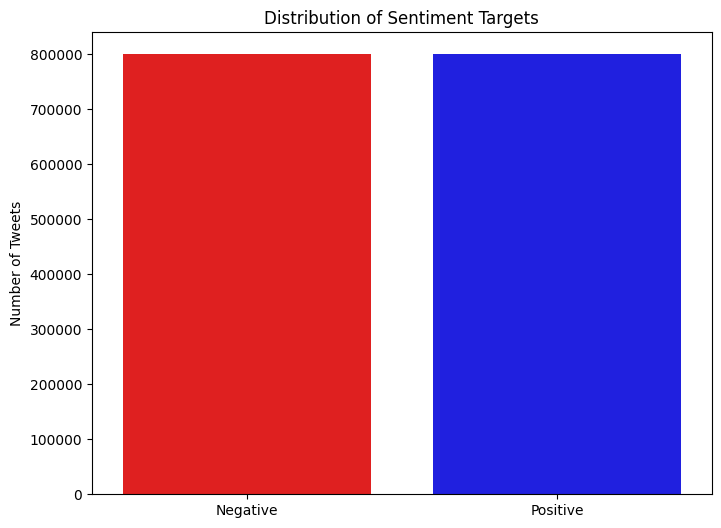

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_counts = df['target'].value_counts()
labels = ['Negative', 'Positive']

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=target_counts.values, palette=("red","blue"))
plt.title('Distribution of Sentiment Targets')
plt.ylabel('Number of Tweets')
plt.show()

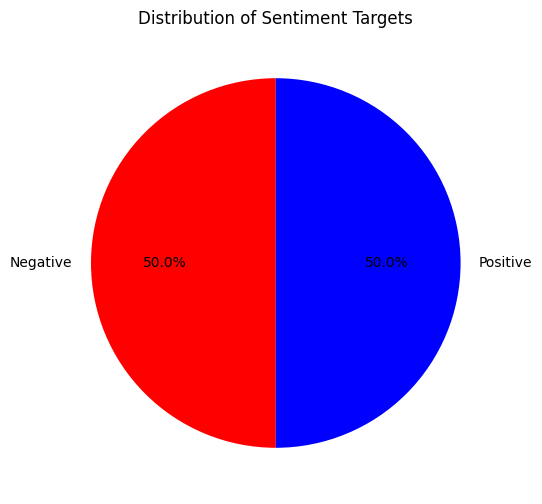

In [ ]:
# pie chart plot
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=("red", "blue"))  # Changes here
plt.title('Distribution of Sentiment Targets')

plt.show()

The amount of data for each label (positive or negative) is balanced with each label amounting to 800,000 data

### Data reduction

Because the dataset is very large with 1.6 million data, i decided to reduce the data proportionally

In [ ]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 2.2 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/11.1 MB 2.8 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.1 MB 3.2 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.1 MB 3.6 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/11.1 MB 3.4 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/11.1 MB 3.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.1 MB 3.4 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.1 MB 3.3 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.1 MB 3.3 MB/s eta 0:00:02
   -------------------------- -----

In [ ]:
from sklearn.model_selection import train_test_split

train_df, reduced_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['target'])

print(f"Original Dataset Shape: {df.shape}")
print(f"Reduced Dataset Shape: {reduced_df.shape}")


Original Dataset Shape: (1600000, 2)
Reduced Dataset Shape: (160000, 2)


The reduced data is loaded into a new DataFrame called **reduced_df**, trimming **90%** of the original data leaving only **160,000** data entries.

<ipython-input-23-c347c643ea54>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_reduced, y=target_counts_reduced.values, palette=("red", "blue"))


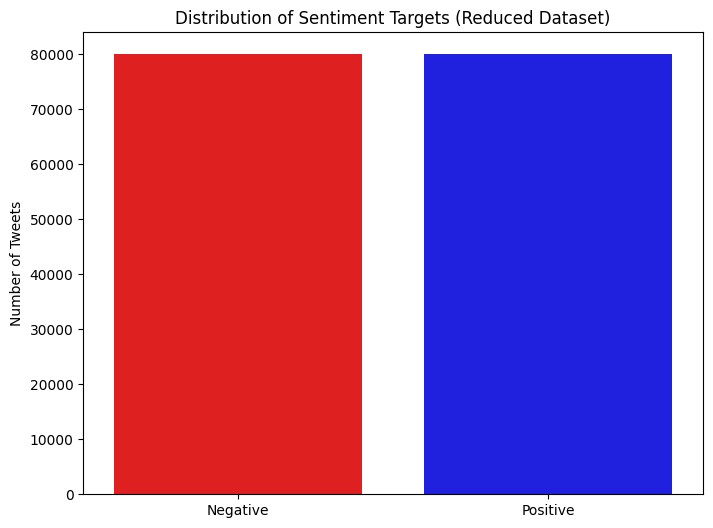

In [ ]:
target_counts_reduced = reduced_df['target'].value_counts()
labels_reduced = ['Negative', 'Positive']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels_reduced, y=target_counts_reduced.values, palette=("red", "blue"))
plt.title('Distribution of Sentiment Targets (Reduced Dataset)')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
reduced_df['text_length'] = reduced_df['text'].str.len()

# find out the average, maximum, and minimum text length
avg_length = reduced_df['text_length'].mean()
max_length = reduced_df['text_length'].max()
min_length = reduced_df['text_length'].min()

print(f"Average text length: {avg_length}")
print(f"Maximum text length: {max_length}")
print(f"Minimum text length: {min_length}")

Average text length: 74.07328125
Maximum text length: 348
Minimum text length: 7


From here we know that the text length range is between (7 to 348 characters).

To get more informative data, below I will map the length distribution of each text from the dataset.

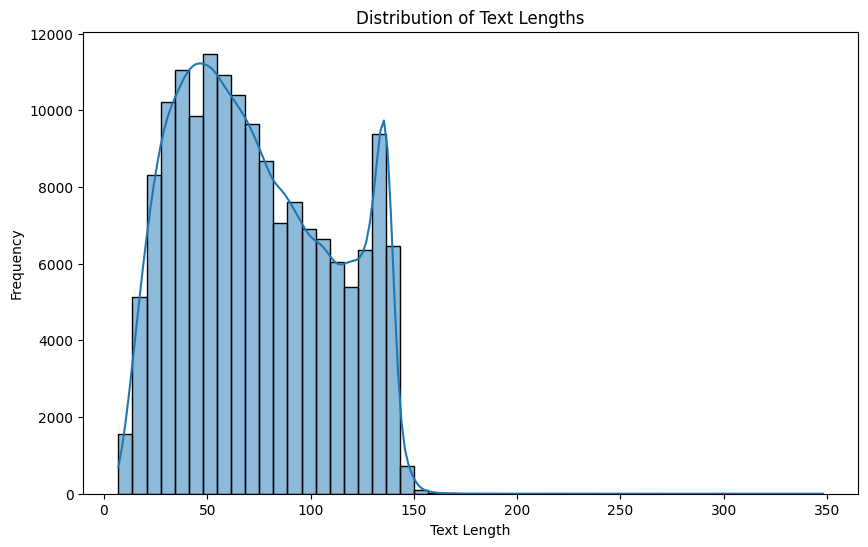

In [ ]:
# Distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['text_length'], bins=50, kde=True)  # using histogram with KDE
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

* Moderate text length: Not too short (context enough), and not too long (computationally efficient). So the data will fit the BERT model because **BERT excels at understanding short contexts**, where relationships between tokens are more easily captured by **self-attention** mechanisms.
* No significant outlier distribution at extreme lengths (e.g. > 300 characters)
* With this distribution, we think it would be more efficient to use **Dynamic Padding**. Where Dynamic padding means the padding length will be adjusted based on the longest text in each batch, not the entire static dataset.
* **Truncation may not occur too often** because the average character length is under 150 characters (the resulting token will probably not be more than the *maximum sequence length* of BERT, namely a token of **512 tokens** if you look at the distribution of character lengths like This).
* Datasets with shorter text will allow for faster latency and processing, as BERT works more efficiently on short text

#### Saving df into drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#reduced_df.to_csv('/content/drive/MyDrive/ASG/Dataset Tex Mining Project/sentiment_analysis_dataa.csv', index=False)

#### **Conclusion in Dataset Exploration:**

* The initial dataset used contained 1.6 million data with **6 features** which I then carried out **dimensionality reduction** to become **2 features**, namely target (sentiment label) and text (text content). Sentiment labels consist of two categories, namely **0 (negative) and 4 (positive)**, with a balanced distribution (800,000 data each).
* Clean dataset from null/missing videos
* To reduce the size of a very large dataset, **data reduction** is carried out proportionally to 160,000 data (10% of the initial data), while maintaining a balanced label distribution.
* Text length analysis shows that the average text length is 74 characters, with a length ranging from 7 to 348 characters. Text distribution tends to be under 150 characters, making it suitable for use with BERT models. With dynamic padding, the BERT model can utilize memory and computation efficiently, and capture short text context optimally using a self-attention mechanism.

## **Preprocessing Text dengan BERT**

Based on initial objectives, dataset exploration results and consideration of the computing resources i have. I chose to use **BERT (Bidirectional Encoder Representation from Transformer**) in text processing (**NLP**).

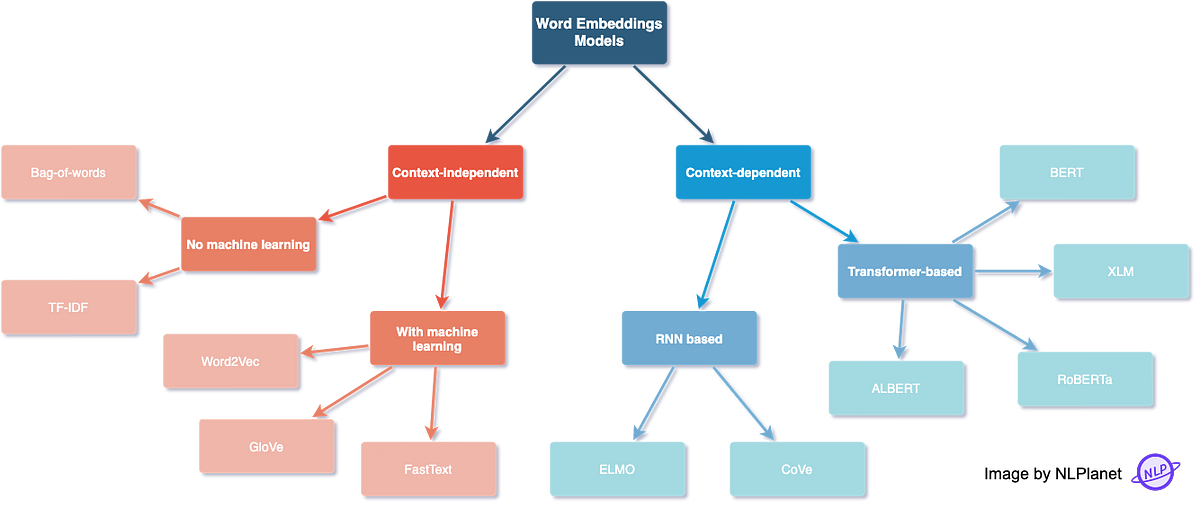

**Considerations for Using BERT in This Project**:

1. The topic raised is "**Sentiment Analysis**", so a model is needed that is able to capture the context and nuances of text well to increase the accuracy of sentiment classification.
2. We want to strive to achieve **maximum results**, leveraging newer technologies in natural language processing (NLP) to overcome the limitations of previous approaches.
3. As in the picture above, **Context Independent is separate from Context Dependent**. In context independence, it can produce the same vector representation for each text because it does not pay attention to the context of a text. For example **"I'am watering the flower"** with **"I'am drinking a water"**, the word **"water"** here will have a different vector value if using BERT (context dependent) because the word is used in different contexts
4. **Using BERT is also an interesting new challenge**, considering that I have used a word embedding-based approach with traditional machine learning algorithms several times in projects in previous semesters such as in the *machine learning* course.

In [ ]:
# library
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd

**Tokenizer**

* **BERT-Base (Cased)** : BERT model that preserves the case of the input text. For example, "**Apple**" and "**apple**" would be considered **different**.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Example : tokenizer dari BERT

In [ ]:
text = "Hello hello, I am Rendra from Binus!"
tokens = tokenizer.tokenize(text)
print(tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

['Hello', 'hello', ',', 'I', 'am', 'Ren', '##dra', 'from', 'Bin', '##us', '!']
[8667, 19082, 117, 146, 1821, 16513, 7412, 1121, 21700, 1361, 106]


**Explanation :**

* This Tokenization function is to break a text into smaller pieces called tokens.
* With the **BERT** model which is **cased**, it will take into account the difference between upper and lower case letters. So, the words "hello" and "Hello" will be perceived differently.
* tokens_id: Converts these tokens into IDs that are used by the model to perform further computations.

In [ ]:
class Dataset(torch.utils.data.Dataset):

    # To initialize the dataset, prepare text and labels
    def __init__(self, reduced_df):

        # Take the modified 'target' column directly in the dataframe
        self.labels = reduced_df['target'].tolist()
        # Tokenize each text, dynamic padding, active truncation and return output in PyTorch tensor ("pt") format.
        self.texts = [tokenizer(text,
                                padding=True, truncation=True,
                                return_tensors="pt") for text in reduced_df['text']]

    # Function to return all labels from a dataset
    def classes(self):
        return self.labels

    # Fungsii untuk mengembalikan panjang dataset (jumlah total data)
    def __len__(self):
        return len(self.labels)

    # Function to return the length of the dataset (total amount of data)
    def get_batch_labels(self, idx):
        # Retrieves labels for a specific batch
        return np.array(self.labels[idx])

    # Function to retrieve batches of text based on index
    def get_batch_texts(self, idx):
        # Retrieves processed text (tokenization) for a specific batch
        return self.texts[idx]

    # Function to retrieve items based on index (batch text and labels)
    def __getitem__(self, idx):
        # Retrieves text and labels for a specific batch
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        # Returns batches of text and labels
        return batch_texts, batch_y

In [ ]:
def collate_fn(batch):
    # Compiles the input_ids and attention_mask of each batch
    input_ids = [item[0]['input_ids'].squeeze(0) for item in batch]  # Retrieve  input_ids
    attention_mask = [item[0]['attention_mask'].squeeze(0) for item in batch]  # Retrieve  attention_mask
    labels = torch.tensor([item[1].item() for item in batch])      # Retrieve label from item batch (second data)

    # Pad input_ids and attention_mask to maximum length in batch
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels

#### **Splitting Data**

**Splitting:**

df_train: 80% of data for training

df_val: 10% of data for validation

df_test: 10% of data for testing

In [ ]:
np.random.seed(112) # Randomly shuffle the order of data in reduced_df with a fixed seed (so that the results can be reproduced).
df_train, df_val, df_test = np.split(reduced_df.sample(frac=1, random_state=42),
                                     [int(.8*len(reduced_df)), int(.9*len(reduced_df))])

print(len(df_train),len(df_val), len(df_test))

128000 16000 16000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


**Hasil:**

128.000 = data training

16.000 = data validasi

16.000 = data testing/uji

#### **Model classification untuk BERT**

In [ ]:
#!pip install torchvision transformers

In [ ]:
from torch import nn
from transformers import BertModel

# building models with neural networks (nn)
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout) # dropout to prevent overfitting
        self.linear = nn.Linear(768, 2) # the output is 2 (0 for negative labels and 1 for positive)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

I use ReLU (Rectified Linear Unit) because RelU will convert the linear output into positive or zero values, which helps the model learn non-linear representations.

#### **Training Data**

In [ ]:
# check whether the GPU is active
torch.cuda.is_available()

True

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

# Determine the number of epochs and learning rate
EPOCHS = 4
LR = 1e-6
BATCH_SIZE = 32
model = BertClassifier()

def train(model, train_data, val_data, learning_rate, epochs):
    # Initialize dataset and data loader
    train, val = Dataset(train_data), Dataset(val_data)

    # Uses a large Batch_size to make optimal use of the GPU
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # Cross entropy loss and optimizer Adam
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Using device : GPU
    device = torch.device("cuda")
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch_num in range(epochs):
        # Variables to store accuracy and loss during training
        total_acc_train = 0
        total_loss_train = 0

        # Training for each epoch
        for train_input, train_label in tqdm(train_dataloader):
            # Moving data to device (GPU)
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            # Forward pass: calculates the output of the model
            output = model(input_id, mask)

            # calculates loss
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            # calculates akurasi
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Backward pass: calculates gradien
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Evaluation on validation data
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                # Moving data to device (GPU)
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                # Forward pass on validation data
                output = model(input_id, mask)

                # calculates loss validasi
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                # calculates akurasi validasi
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Displays results per epoch
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')


# run the training process
train(model, df_train, df_val, LR, EPOCHS)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

100%|██████████| 4000/4000 [17:24<00:00,  3.83it/s]


Epochs: 1 | Train Loss:  0.015             | Train Accuracy:  0.753             | Val Loss:  0.013             | Val Accuracy:  0.813


100%|██████████| 4000/4000 [17:32<00:00,  3.80it/s]


Epochs: 2 | Train Loss:  0.012             | Train Accuracy:  0.836             | Val Loss:  0.012             | Val Accuracy:  0.824


100%|██████████| 4000/4000 [17:34<00:00,  3.79it/s]


Epochs: 3 | Train Loss:  0.011             | Train Accuracy:  0.855             | Val Loss:  0.012             | Val Accuracy:  0.826


100%|██████████| 4000/4000 [17:33<00:00,  3.80it/s]


Epochs: 4 | Train Loss:  0.010             | Train Accuracy:  0.873             | Val Loss:  0.012             | Val Accuracy:  0.826


#### **Evaluasi Model**

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # Initialize CrossEntropyLoss before device assignment
    criterion = nn.CrossEntropyLoss()

    device = torch.device("cuda")

    # Move the model and the loss function to the GPU
    model = model.to(device)
    criterion = criterion.to(device)

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            # 1. Clamp value:
            test_label = torch.clamp(test_label, 0, 1)

            # 2. Konversi Tipe Data dan Pindahkan ke Device:
            test_label = test_label.type(torch.long).to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Akurasi Pengujian: {total_acc_test / len(test_data): .3f}')

evaluate(model, df_test)

Akurasi Pengujian:  0.833


In [ ]:
from sklearn.metrics import classification_report

def evaluate_with_report(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    device = torch.device("cuda")
    model = model.to(device)

    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = torch.clamp(test_label, 0, 1).type(torch.long).to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            predicted = output.argmax(dim=1)

            true_labels.extend(test_label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    print(classification_report(true_labels, predicted_labels))

evaluate_with_report(model, df_test)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      7991
           1       0.82      0.86      0.84      8009

    accuracy                           0.83     16000
   macro avg       0.83      0.83      0.83     16000
weighted avg       0.83      0.83      0.83     16000



**Model Performance:**

The model has an accuracy of 83%, which shows the overall performance of the model predictions on both labels.
The performance of precision, recall, and F1-Score is balanced between label 0 and label 1, which is normal because the dataset is balanced (50%-50%). **This is why we pay close attention to our dataset by doing Dataset Exploration**. We don't just do EDA as a formality.


**Comparison of Label 0 vs Label 1:**
The model is more accurate in detecting label 0 (precision 0.85 vs 0.82).
The model is more sensitive in detecting label 1 (recall 0.86 vs 0.81).

**Conclusion:**
overall, the performance of this model is quite good (83%).

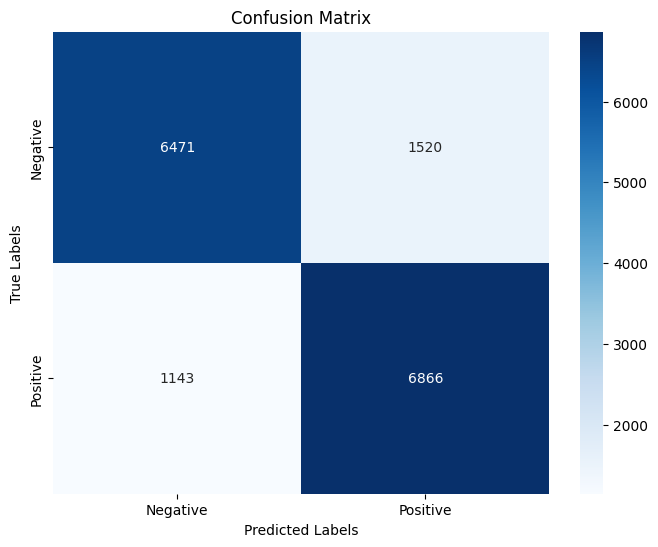

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_with_confusion_matrix(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    device = torch.device("cuda")
    model = model.to(device)

    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = torch.clamp(test_label, 0, 1).type(torch.long).to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            predicted = output.argmax(dim=1)

            true_labels.extend(test_label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_with_confusion_matrix(model, df_test)

- **True Negative** (6471): Number of Negative data correctly predicted as Negative.
- **False Positive** (1520): The number of Negative data that was incorrectly predicted as Positive.
- **False Negative** (1143): The number of Positive data that were incorrectly predicted as Negative.
-**True Positive** (6866): The number of Positive data that were correctly predicted as Positive.

From this confusion matrix, we can see that **the model is more accurate in detecting label 0 (Negative) than label 1 (Positive)**, which is in accordance with the precision results in the previous classification report:

**Precision label 0**: 0.85 → This means, of all Negative predictions, 85% are correct.
**Precision label 1**: 0.82 → Of all Positive predictions, 82% were correct.
This is supported by detailed numbers in the confusion matrix:

For label 0 (Negative):

6471 samples were correctly classified as Negative (True Negative).
Only 1520 samples were incorrectly classified as Positive (False Positive).
For label 1 (Positive):

6866 samples were correctly classified as Positive (True Positive).
However, 1143 samples were incorrectly classified as Negative (False Negative).

#### Import model as pickle

In [ ]:
import pickle

# Save the model
with open('model_BERT.pkl', 'wb') as f:
    pickle.dump(model, f)

I created pickle so that I don't need to train again, the next time I want to use this BERT model

#### Testing

In [ ]:
# Test some new text to the model
# Load the pickle model earlier
with open('model_BERT.pkl', 'rb') as f:
    model = pickle.load(f)

# Function for predicting new sentences
def predict_sentiment(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Gets input_ids and attention_mask from the input dictionary
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        # Provides input_ids and Attention_mask as separate arguments
        outputs = model(input_ids, attention_mask)
    predicted_class = torch.argmax(outputs, dim=1).item()  # Access the output directly
    return predicted_class

# example:
new_texts = [
    "This is a great product!",
    "I'm really great disappointed with this prdouct.",
    "The service was amazing; I’m so satisfied and will definitely come back.",
    "The ticket prices are amazing—amazingly expensive."
]

for text in new_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")
    print("-" * 80)

Text: This is a great product!
Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Text: I'm really great disappointed with this prdouct.
Predicted Sentiment: Negative
--------------------------------------------------------------------------------
Text: The service was amazing; I’m so satisfied and will definitely come back.
Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Text: The ticket prices are amazing—amazingly expensive.
Predicted Sentiment: Negative
--------------------------------------------------------------------------------


4th text : "Text: The ticket prices are amazing—amazingly expensive."

In fact, I deliberately made it that way, because it is quite tricky/trapping where the word amazing-amazingly has a connotation that seems "positive" but because I added the word "expensive" in this context it should be "negative". And the BERT model is able to learn the context in the statement


Later I will also compare the same text as this with the BoW model which prioritizes frequency (not contextual)

## **Compare dengan model tradisional**

In [ ]:
df_2 = reduced_df.drop(columns=['text_length'])

df_2.head()

,target,text
668431,0,Wow TWitter has serious people who need prayer...
971539,1,"@Rick_Bayless Beautiful, bet you are going to..."
1560003,1,@ihuntmidgets Thanks!
1085642,1,"Thanks for the support, everyone. I feel bette..."
1095582,1,@angiedarintip nah we should spam his Twitter ...


In [ ]:
df_2.shape

(160000, 2)

Just assume that i use a context independent model with BoW with SVM machine learning for the classification task

#### **Preprocessing**

In [ ]:
pip install nltk


  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.6 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)


**I have carried out the Dataset Exploration process at the beginning **

In [ ]:
import nltk
nltk.download('wordnet') # untuk kosakata bahasa Inggris
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'\W', ' ', text)  # remove symbol / special character
    text = re.sub(r'\s+',' ',text) # remove double white space
    text = text.lower()  # change all text into lowercase (Case Folding)
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

df_2['cleaned_text'] = df_2['text'].apply(preprocess_text)

Explanation:

After exploring the dataset, I found out that the text data was in **English** so the library tool I used was in English.  

1. Tokenization:
Splitting text into individual words or tokens. For example "Text mining" becomes "text" and "mining"

2. Removal of Stopwords: Removing words that are common and do not provide much information. For example "and", "or", "then"

3. Deleting double white space: For example "rendra‎ ‎ dwi" becomes "rendra dwi", then I also delete symbols and links if they are in the text

3. Lemmatization is a concept like stemming which changes words into their basic form.
For example: "teaching" becomes "teach".

But here I don't use stemming, but rather **lemitization**, because it pays more attention to the morphological and grammatical context, where the results will be more precise than stemming.

**Splitting Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_2['cleaned_text'] # text that has been processed
y = df_2['target']  # targets that I have identified earlier have 2 types of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #traininng 80% dan 20% data buat testing

**Word embedding**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Metode TF-IDF
tfidf_vectorizer = TfidfVectorizer() # object to carry out TF-IDF vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) #apply TF-IDF for training data
X_test_tfidf = tfidf_vectorizer.transform(X_test) #apply TF-IDF for testing data



```
# !
```

This bag of words simply counts the frequency of occurrence of words in a corpus/set of data.

In [ ]:
from sklearn.svm import SVC

# SVM
svm_params = {'C': 1, 'kernel': 'linear'}
svm_classifier = SVC(**svm_params)
# fitting model
svm_classifier.fit(X_train_tfidf, y_train)

SVC(C=1, kernel='linear')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# SVM dengan TF-IDF
y_pred_svm_tfidf = svm_classifier.predict(X_test_tfidf)
print(classification_report(y_pred_svm_tfidf,y_test))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     15496
           1       0.78      0.75      0.77     16504

    accuracy                           0.76     32000
   macro avg       0.76      0.76      0.76     32000
weighted avg       0.76      0.76      0.76     32000



**Overall Accuracy:** 76% → The model correctly predicted 76% of the total 32000 samples.


**Label Performance:**
The model is slightly better at predicting label 1 (Positive) because its precision is higher (0.78 vs 0.75).
However, the recall for label 0 (77%) is higher than the recall for label 1 (75%), meaning the model is better at capturing negative samples.


**Conclusion**:
The model shows balanced performance between the two classes with an overall accuracy of 76%. However, there is a slight difference in precision and recall between labels 0 and 1. The model tends to be more precise on label 1 but has higher recall on label 0.

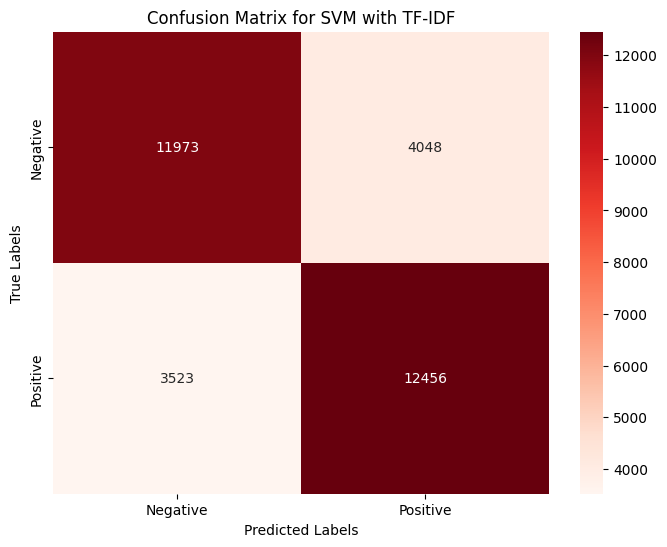

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for SVM with TF-IDF")
plt.show()

- **True Negative** (11973): Number of Negative samples correctly predicted as Negative.
- **False Positive** (4048): The number of Negative samples that were incorrectly predicted as Positive.
- **False Negative **(3523): Number of Positive samples that were incorrectly predicted as Negative.
- **True Positive** (12456): The number of Positive samples that were correctly predicted as Positive.

**Conclusion :**

The model has quite good performance. Overall, the model tends to be better at predicting Positive labels than Negative labels, because the number of True Positives is higher than True Negatives.

In [ ]:
# Save model as pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

In [ ]:
new_texts = [
     "This is a great product!",
     "I'm really great disappointed with this prdouct.",
     "The service was amazing; I’m so satisfied and will definitely come back.",
     "The ticket prices are amazing—amazingly expensive."
]

def predict_sentiment_svm(text):
    text = preprocess_text(text)
    text_tfidf = tfidf_vectorizer.transform([text])
    sentiment = svm_classifier.predict(text_tfidf)[0]
    return sentiment

for text in new_texts:
    sentiment = predict_sentiment_svm(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment (SVM): {'Positive' if sentiment == 1 else 'Negative'}")
    print("-" * 80)

Text: This is a great product!
Predicted Sentiment (SVM): Positive
--------------------------------------------------------------------------------
Text: I'm really great disappointed with this prdouct.
Predicted Sentiment (SVM): Negative
--------------------------------------------------------------------------------
Text: The service was amazing; I’m so satisfied and will definitely come back.
Predicted Sentiment (SVM): Positive
--------------------------------------------------------------------------------
Text: The ticket prices are amazing—amazingly expensive.
Predicted Sentiment (SVM): Positive
--------------------------------------------------------------------------------


If we compare it with the sentiment prediction results from the BERT model, the fourth text of the prediction results is: "Negative". This shows that BERT is able to understand context more deeply, while BoW (Bag of Words) only considers the frequency of word occurrence without paying attention to the relationship between words. In this case, the presence of the word "amazing" causes BoW to predict sentiment as "Positive" because the word is often associated with positive sentiment. On the other hand, BERT can understand **the overall context of the text**, so that even though there is the word "amazing", BERT is still able to recognize that the text contains negative sentiment